## 依赖包
<!-- **Author**: `zwy` -->


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import random
import shutil

plt.ion()   # 交互模式可以动态显示图像

### 硬件选择 GPU

In [2]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 数据加载及处理


### 下载数据集
可以从Google Drive / Github / 其他数据地址下载数据

In [ ]:
!rm -rf CNN
!git clone https://github.com/Zwysun/CNN.git
!ls

### 数据预处理
利用transforms对图片进行预处理，可以分别针对训练集和验证集采取不同的处理方法


In [3]:
# 直接加载数据集MINST

# 训练集 扩充及正则化
# 测试集 仅正则化

# 图像变换操作
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1307], [0.3081])
    ]),
}

# 下载公共数据集
DOWNLOAD_MNIST=True
train_dataset = datasets.MNIST( root="./mnist",  # 设置数据集的根目录
    train=True,  # 是否是训练集
    transform=data_transforms['train'],  # 对数据进行转换
    download=DOWNLOAD_MNIST
    )
test_dataset = datasets.MNIST( root="./mnist", 
    train=False,  # 测试集，所以false
    transform=data_transforms['test'], 
    download=DOWNLOAD_MNIST
    )
train_size = int(0.9 * len(train_dataset))   # 训练集划分为训练集和验证集, 比例
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

image_datasets = {'train':train_dataset, 'val':val_dataset, 'test':test_dataset}
# 数据
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], 
                batch_size=128, shuffle=True, num_workers=4)
                for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['test'].classes
print (dataset_sizes)
print (image_datasets)
print (class_names)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!
{'train': 54000, 'val': 6000, 'test': 10000}
{'train': <torch.utils.data.dataset.Subset object at 0x7f92f45819e8>, 'val': <torch.utils.data.dataset.Subset object at 0x7f92f4581358>, 'test': Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.1307], std=[0.3081])
           )}
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 显示部分图片

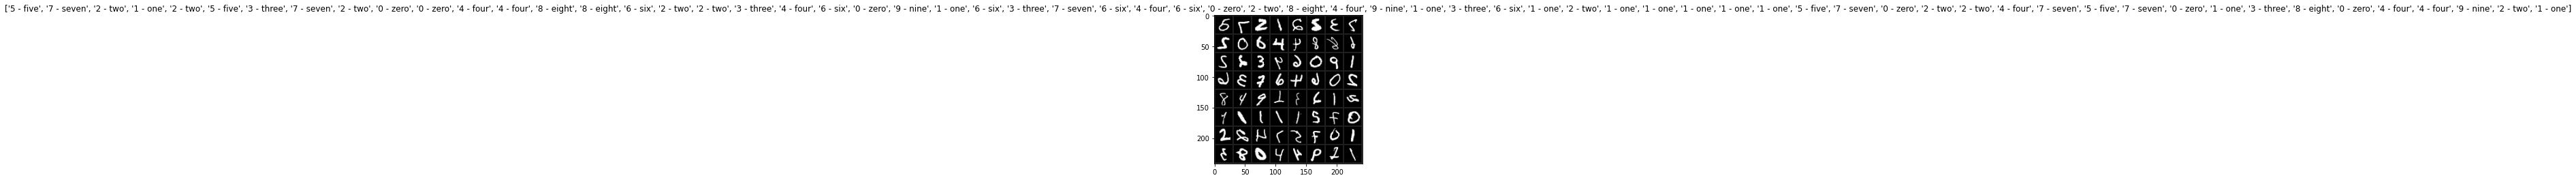

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])   # RGB
    mean = np.array([0.1307])
    std = np.array([0.3081])   # 灰度图
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 模型训练

In [6]:
#训练过程
def train_model(model, dataloaders, loss_function, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loader = dataloaders['train']
    val_loader = dataloaders['val']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # 记录把所有数据集训练+测试一遍需要多长时间
        startTick = time.time()

        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:  # 对于训练集的每一个batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            out = model(inputs)  # 送进网络进行输出
            _, preds = torch.max(out, 1)
            loss = loss_function(out, labels)  # 获得损失
        
            optimizer.zero_grad()  # 梯度归零
            loss.backward()  # 反向传播获得梯度，但是参数还没有更新
            optimizer.step()  # 更新梯度
            scheduler.step()  # 更新学习率

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    'train', epoch_loss, epoch_acc))

        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            out = model(inputs)  # 获得输出
        
            _, preds = torch.max(out, 1)
            # torch.max()返回两个结果，
            # 第一个是最大值，第二个是对应的索引值；
            # 第二个参数 0 代表按列取最大值并返回对应的行索引值，1 代表按行取最大值并返回对应的列索引值。
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)  # 找出预测和真实值相同的数量，也就是以预测正确的数量
        
        epoch_loss = running_loss / dataset_sizes['val']
        epoch_acc = running_corrects.double() / dataset_sizes['val']
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    'val', epoch_loss, epoch_acc))
                    
        timeSpan = time.time() - startTick
        print("Time: %dS"%(timeSpan))
        print()

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 搭建网络结构

In [7]:
# 搭建网络
class myNet(nn.Module):
  def __init__(self):
    super(myNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(          #(1,28,28)
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2   #padding=(kernelsize-stride)/2
        ),#(16,28,28)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)#(16,14,14)
        )
    self.conv2 = nn.Sequential(#(16,14,14)
        nn.Conv2d(16, 32, 5, 1, 2),#(32,14,14)
        nn.ReLU(),#(32,14,14)
        nn.MaxPool2d(2)#(32,7,7)
        )
    self.out = nn.Linear(32*7*7, 10)
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x) #(batch,32,7,7)
    x = x.view(x.size(0), -1) #(batch,32*7*7)
    output=self.out(x)
    return output

# 
model_ft=myNet()
model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.03)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print(model_ft)


myNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
# 可视化网络
!pip install tensorwatch
import tensorwatch as tw


In [ ]:
net = myNet()
tw.draw_model(net, [1, 1, 28, 28])  # 有问题

In [21]:
# 可视化工具
# https://lutzroeder.github.io/netron/
os.chdir("/content")
torch.save(model_ft,'draw.pth')

## 训练

In [8]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)
model_ft.eval()
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    out = model_ft(inputs)  # 获得输出

    _, prediction = torch.max(out, 1)
    # torch.max()返回两个结果，
    # 第一个是最大值，第二个是对应的索引值；
    # 第二个参数 0 代表按列取最大值并返回对应的行索引值，1 代表按行取最大值并返回对应的列索引值。
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)  # 找出预测和真实值相同的数量，也就是以预测正确的数量

test_loss = running_loss / dataset_sizes['test']
test_acc = running_corrects.double() / dataset_sizes['test']
print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            'Test', test_loss, test_acc))

Epoch 1/50
----------
train Loss: 1.5694 Acc: 0.5329
val Loss: 1.4816 Acc: 0.5437
Time: 13S

Epoch 2/50
----------


KeyboardInterrupt: ignored

### 测试和保存

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # 挂载云盘

In [ ]:
os.chdir("/content")
torch.save(model_ft,'CIFAR.pth')
!ls

CNN  light.pth	sample_data


In [ ]:
os.chdir("/content/drive/My Drive")
!ls
torch.save(model_ft,'light.pth')

'2020 年日历.gsheet'  'Colab Notebooks'   light.pth  'Science Journal'


测试一下

In [ ]:
# 训练集 扩充及正则化
# 验证集 仅正则化
data_dir = 'CNN/dataset/morning'    # 数据目录
!rm -rf CNN/dataset/morning/train
!rm -rf CNN/dataset/morning/val
data_transforms = transforms.Compose([
        transforms.Grayscale(1),
        transforms.CenterCrop(1080),
        transforms.Resize(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.1307], [0.3081])      # 灰度图标准化参数
    ])

test_datasets = datasets.ImageFolder(data_dir, data_transforms)
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

dataset_sizes = len(test_datasets)
class_names = test_datasets.classes
print (dataset_sizes)
print (test_datasets)
print (class_names)

190
Dataset ImageFolder
    Number of datapoints: 190
    Root location: CNN/dataset/morning
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               CenterCrop(size=(1080, 1080))
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.1307], std=[0.3081])
           )
['0', '10', '15', '20', '25', '30', '35', '40', '45', '5', '50', '55', '60', '65', '70', '75', '80', '85', '90']


In [ ]:
test_dataloaders=dataloaders['val']

In [ ]:
#show acc
model = torch.load('light.pth')
eval_loss = 0.
eval_acc = 0.
s= 0.
with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                #s =s + int(class_names[preds[j]])
                #print(class_names[preds[j]])
                #if int(class_names[preds[j]]) == int(labels[j]):
                if class_names[preds[j]] == class_names[int(labels[j])]:
                    s = s+1
print (s)
print (s/(len(test_dataloaders) * 4))

3.0
0.015625
